<center>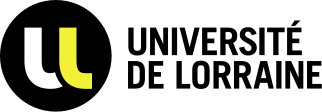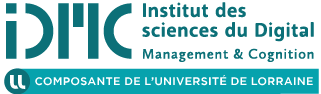</center>

<h1><center><strong><font color="Teal">Data Mining for Natural Language Processing<br/> Master 2 Natural Language Processing <br/> Lab 3 : Unsupervised Approaches to Explore Data</font></strong></center></h1>

<center>
<h3><a href="https://gguibon.github.io/">Gaël Guibon</a></h3>
<email>gael.guibon@univ-lorraine.fr</email>
<br/>
Year 2022-2023
</center>

<h3><center><font color="green"><strong>Correction 💯</strong></font></center></h3>

<center>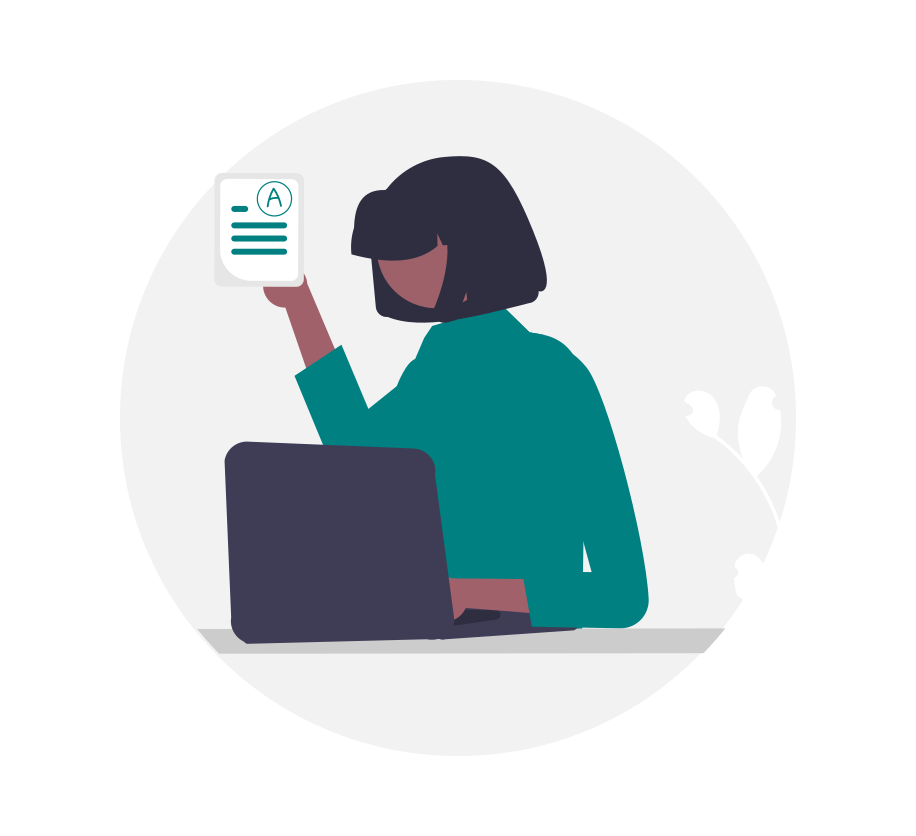</center>

------------------------

# <font color="teal">**Usage (a.k.a. README)**</font>

This is a python notebook that we will use for the lab today. It is hosted by Google Colab to make it easy to share. You should be able to edit it, but your edits won't be saved, so I don't recommend it.


In order to work with it and answer the questions, you can either use it in Google Colab, download it and use it in VSCode (or other IDE) or Jupyter Notebook.

**Usage in Google Colab.** If you own a Google account, you can upload a copy of this file and edit it with saves. To do so got to "File" > "Save a copy in Drive". Don't forget to use the interactive Table of Content on the left panel.

**Local Usage.** You can download it either as a jupyter notebook (.ipynb) or as a python programme (.py) using the File>Download menu (Fichier>Télécharger in French). We recommend that you download it as a Jupyter Notebook to work on and edit on your own laptop.



## <font color="teal">"Quality of Life" Tips</font>

- To better understand when you need to do something, please for the 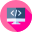 **TODO!** marks sprinkled across the lab!

- Run the small pieces of code (named Code Cells) below to see what they do (in Jupyter Notebook or Google Colab, press the small \"play\" button on the left, or press ctrl+enter in the code box)
- On Google Colab and VSCode, you can fold and unfold section and subsections to better display the notebook. Try to click on the arrow of this '"Quality of Life" Tips' section as below:
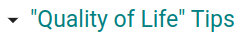

## <font color="teal">Install local python environnement</font>
At home you may want to use Python locally. Here are the steps:
1. Download the latest Python (Python3 not 2) from here: [https://www.python.org/downloads/](https://www.python.org/downloads/)
2. Install it (if you are using Ubuntu 16.04 you already have Python installed)

Start using it:
- Open terminal(unix/mac) or CommandLine(windows), type `python` to start an interactive python environnement
- Create a file named `my_super_program.py` and type `print('hello')` inside. Execute this file by typing `python3 my_super_program.py`.

To code you may need an IDE for smoother coding. I would suggest [Visual Studio Code](https://code.visualstudio.com/Download).

# <font color="teal">**Objectives**</font>

------------------------

In this lab you will actually use multiple approaches to represent the data in an unsupervised way. You will also learn how to use PyTorch and complete some parts of PyTorch code. For each approach you will plot the embbeding space.



# <font color="teal">**Preparation**</font>

### Download the corpora
(can also be manually downloaded here: https://gitlab.com/gguibon/idmc-storage/)

### Tweets.csv = [Twitter US Airline Sentiment dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)

```
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").
```

### Political-media-DFE.csv = [Classification of Political Social Media dataset](https://data.world/crowdflower/classification-of-pol-social)

```
Contributors looked at thousands of social media messages from US Senators and other American politicians to classify their content. Messages were broken down into audience (national or the tweeter's constituency), bias (neutral/bipartisan, or biased/partisan), and finally tagged as the actual substance of the message itself (options ranged from informational, announcement of a media appearance, an attack on another candidate, etc.) Added: August 5, 2015 by CrowdFlower | Data Rows: 5000
```

In [ ]:
! wget https://gitlab.com/gguibon/idmc-storage/-/raw/main/tweets.csv
! wget https://gitlab.com/gguibon/idmc-storage/-/raw/main/Political-media-DFE.csv

--2024-01-25 15:02:40--  https://gitlab.com/gguibon/idmc-storage/-/raw/main/tweets.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/plain]
Saving to: ‘tweets.csv’

tweets.csv          100%[===================>]   3.26M  --.-KB/s    in 0.05s   

2024-01-25 15:02:41 (69.7 MB/s) - ‘tweets.csv’ saved [3421431/3421431]

--2024-01-25 15:02:41--  https://gitlab.com/gguibon/idmc-storage/-/raw/main/Political-media-DFE.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4309577 (4.1M) [text/plain]
Saving to: ‘Political-media-DFE.csv’

Political-media-DFE 100%[===================>]   4.11M  11.4MB/s    in 0.4s    

2024-01-25 15:02:41 (11.4 MB/s) - 

Now let's import the Pandas module and load our datasets as Dataframes

In [ ]:
import pandas as pd
df_airline = pd.read_csv('tweets.csv')
df_pol = pd.read_csv('Political-media-DFE.csv', encoding='latin-1')

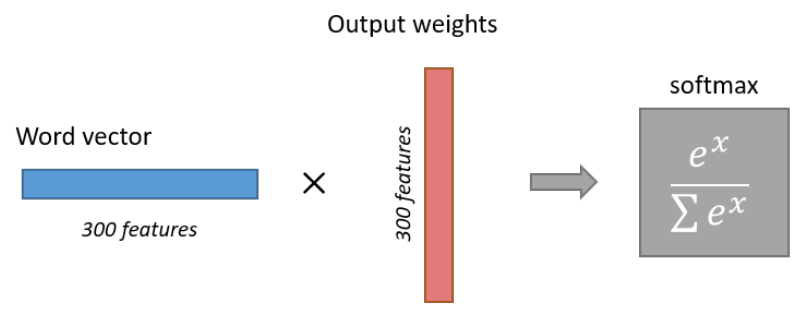

#### 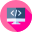 **TODO1: complete the preparation**

**Re train** pol (*i.e.* political) embeddings and **train** airline embeddings using **Word2Vec skip gram** (copied and pasted from lab session 2 correction) for later use

In [ ]:
# Usage of Phrases and Phraser from gensim
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)

from tqdm import tqdm
def tokenize_url_hashtags(corpus, tweets=False):
  if tweets:
    tokenizer = TweetTokenizer()
  else:
    tokenizer = TreebankWordTokenizer()
    # Life hack : treebank word tokenizer won't keep html code in one token.
    # To preprocess economics news corpus, use tweettokenizer.
  tokenized_sentences = []
  for sample in tqdm(corpus):
    # separating sentences
    for sentence in sent_detector.tokenize(sample):
      tokens = tokenizer.tokenize(sentence)
      tokens = remove_url(tokens)
      tokens = remove_html(tokens)
      tokens = remove_hashtags(tokens)
      tokens = list(map(lambda x: x.lower(), tokens))
      tokenized_sentences.append(tokens)
  return tokenized_sentences

cleaned_pol = tokenize_url_hashtags(df_pol.text.array, tweets=True)
cleaned_airline = tokenize_url_hashtags(df_airline.text.array, tweets=True)

print('number of pol:', len(cleaned_pol))
print('number of pol:', len(cleaned_airline))


from gensim.models.phrases import Phrases, Phraser

def clean_corpus(corpus, threshold=50, tweets=False):
  tokenized_sentences = tokenize_url_hashtags(corpus, tweets=tweets)
  phrases = Phrases(tokenized_sentences, threshold=threshold)

  # This lets you use it with less RAM and faster processing.
  # But it will no longer be possible to update the detector with new training
  # samples
  phraser = Phraser(phrases)

  # Merging multi-word expressions in the tokenization
  clean_corpus = []
  for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])

  return clean_corpus

from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

# We will just get the "WordVectors" parameter from the trained Word2Vec model.
# Otherwise, we could continue training with some more exemples that could be
# fed on the fly to the model.
print("Training the political W2V ...")
pol = Word2Vec(cleaned_pol, vector_size=100, window=5, min_count=1, workers=cpu, sg=0)
pol.train(cleaned_pol, total_examples=len(cleaned_pol), epochs=100)
pol_wv = pol.wv

print("Training the airline W2V ...")
airline_w2v = Word2Vec(cleaned_airline, vector_size=100, window=5, min_count=1, workers=cpu, sg=0)
airline_w2v.train(cleaned_airline, total_examples=len(cleaned_pol), epochs=100)
airline_wv = airline_w2v.wv

################################
### WARNING: following code show different better training options and how to load pre trained model.
### It is quite LONG (~ 10 minutes!). Run it at home afterward out of curiosity.
################################
# pol = Word2Vec(cleaned_pol, size=300, window=5, min_count=3, workers=cpu, sg=1, negative=20) # skipgram with negative sampling (20)
# pol.train(cleaned_pol, total_examples=len(cleaned_pol), epochs=100)
# pol_wv = pol.wv

# print("Training the tweets W2V ...")
# tweets = Word2Vec(cleaned_tweets, size=300, window=5, min_count=3, workers=cpu, sg=0) # sg=0 == CBOW
# tweets.train(cleaned_tweets, total_examples=len(cleaned_tweets), epochs=100)
# tweets_wv = tweets.wv

## downloads and put in memory the famous pre-trained model from Google-News (embedding dimension = 300)
# import gensim.downloader as api
# model = api.load("word2vec-google-news-300")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 14640/14640 [00:02<00:00, 5921.71it/s]


number of pol: 11284
number of pol: 29324
The virtual instance has 2 cpus, that will be used to train the word2vec model
Training the political W2V ...


Training the airline W2V ...


Explore the dataset.

Take a look at the columns:

In [ ]:
df_airline.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

Take a look at the first tweet's `text` and `airline_sentiment` fields content.

Note: This tweets concern user sentiments related to different airline companies. Hence the column label!

(reminder: `iloc[0]` means *locate the element by index*, the index being 0 in this example)

In [ ]:
print('text =', df_airline.text.iloc[0], '| airline_sentiment =', df_airline.airline_sentiment.iloc[0])

text = @VirginAmerica What @dhepburn said. | airline_sentiment = neutral


Let's take a look at the dataframe first 5 elements:

In [ ]:
df_airline.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Now let's see what it's shape is: `(number_of_rows, number_of_columns)`

In [ ]:
df_airline.shape

(14640, 15)

Here you can find some code for exploring the dataset using unsupervised learning (clustering) and visualization. A good clustering would require better tuned features.

If you want to dive into the scikit learn related documentation:
- [CountVectorizer doc](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
- [preprocessing doc](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)

#### 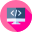 **TODO2: complete the following token to vector mapping**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import numpy as np

def tokens2vectors(tokenCorpus, trained_word2vec, dim=100):
  '''
  transforms our X into a list of list of vec (2D array)

  Args:
    tokenCorpus (list): corpus of tokens represented as a list of
      tokenized texts in which each token is separated by a space.

  Returns:
    Numpy array representing the 2D array of token embeddings from the word2vec
    model pre-trained using Gensim (here pol_wv for political_wordvectors)
  '''
  new_sample = list()
  for sample in tokenCorpus:
    tweetVecs = list()
    for token in sample.split(' '):
      try: tweetVecs.append(trained_word2vec.get_vector(token)  )
      except: tweetVecs.append( np.zeros(dim) )
    new_sample.append(np.mean(tweetVecs, axis=0))
  return np.array(new_sample)

# X = tokens2vectors(df_pol.loc[:, "text"], pol_wv)
X = tokens2vectors(df_airline.loc[:, "text"], airline_wv)

## If you want you can try with a CountVectorizer (token occurrence matrix)
# X = dfTweets.loc[:, "text"]
# cv = CountVectorizer(max_features=300)
# X = cv.fit_transform(X)
# print(X.shape)


# <font color="teal">**Explore Data Using Unsupervised Learning**</font>

Now let's train some KMeans clusetring with 3 target clusters (that we hope will represent positive, neutral and negative sentiments).

- [KMeans documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20, max_iter=300, verbose=0).fit(X)

#### 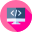 **TODO3:**

- predict the clusters
- display some cluster related info
- complete the quantitative evaluation using the v_measure

In [ ]:
clusters = kmeans.predict(X)


from sklearn.cluster import KMeans

# use the model to predict clusters
clusters = kmeans.predict(X)


# display some cluster related info
from collections import Counter
print('Clusters:', clusters, 'of type', type(clusters))
print('Here is the occurrence counts for each cluster:')
for k,v in dict(Counter(clusters)).items(): print('cluster', k, 'has', v, 'elements')
clusterTendancies = {'positive':list(), 'neutral': list(), 'negative': list()}
for text, sentiment, cluster in list(zip(df_airline.loc[:, "text"], df_airline.airline_sentiment, clusters)):
  clusterTendancies[sentiment].append(cluster)
clusterTendancies = { k:Counter(v) for k,v in clusterTendancies.items() }
print('clusters distribution accross sentiments')
print(clusterTendancies)

print(df_airline.loc[:, "text"].shape, 'cluster.shape', clusters.shape)

# Quantitative evaluation
from sklearn.metrics.cluster import v_measure_score
label2id = {'positive':0, 'neutral':1, 'negative':2}
y_true = np.array([ label2id[sentiment] for sentiment in df_airline.airline_sentiment ])
print('v_measure score:', v_measure_score(y_true, clusters))

Clusters: [2 2 2 ... 2 1 0] of type <class 'numpy.ndarray'>
Here is the occurrence counts for each cluster:
cluster 2 has 3721 elements
cluster 1 has 5289 elements
cluster 0 has 5630 elements
clusters distribution accross sentiments
{'positive': Counter({2: 1172, 1: 626, 0: 565}), 'neutral': Counter({1: 1286, 2: 1065, 0: 748}), 'negative': Counter({0: 4317, 1: 3377, 2: 1484})}
(14640,) hey (14640,)
v_measure score: 0.05001690755855123


We can see the clusters are not that good according to sentiment. The V-Measure score is very low (0-1 range)

This is not suprising considering this is unsupervised learning.

And see in which clusters the first two tweets are assigned:

In [ ]:
print('cluster =', clusters[0], '| text =', df_airline["text"][0], '| airline_sentiment =', df_airline["airline_sentiment"][0])

print('cluster =', clusters[1], '| text =', df_airline["text"][1], '| airline_sentiment =', df_airline["airline_sentiment"][1])

cluster = 2 | text = @VirginAmerica What @dhepburn said. | airline_sentiment = neutral
cluster = 2 | text = @VirginAmerica plus you've added commercials to the experience... tacky. | airline_sentiment = positive


Let's do some **dimension reduction** using TSNE (alternatively you can use other methods: PCA, etc.).

Be aware: TSNE parameters highly affects the visualization which can then lead to opposite interpretations!

- [TSNE documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, learning_rate=100.0, early_exaggeration=2., n_iter=250)
X_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14640 samples in 0.006s...
[t-SNE] Computed neighbors for 14640 samples in 4.978s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14640
[t-SNE] Computed conditional probabilities for sample 2000 / 14640
[t-SNE] Computed conditional probabilities for sample 3000 / 14640
[t-SNE] Computed conditional probabilities for sample 4000 / 14640
[t-SNE] Computed conditional probabilities for sample 5000 / 14640
[t-SNE] Computed conditional probabilities for sample 6000 / 14640
[t-SNE] Computed conditional probabilities for sample 7000 / 14640
[t-SNE] Computed conditional probabilities for sample 8000 / 14640
[t-SNE] Computed conditional probabilities for sample 9000 / 14640
[t-SNE] Computed conditional probabilities for sample 10000 / 14640
[t-SNE] Computed conditional probabilities for sample 11000 / 14640
[t-SNE] Computed conditional probabilities for sample 12000 / 14640
[t-SNE] Computed conditional probabilities for sam

Now we want to display a really pretty plot based on the reduced.

To do so we use the [Plotly library](https://plotly.com/):
- [plotly.express documentation](https://plotly.com/python/plotly-express/)
- [plotly.graph_objects documentation](https://plotly.com/python/graph-objects/)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np


mapColors = {0:'lightseagreen', 1:'blueviolet', 2:'tomato'}
mapSentColors = {'positive':'lightseagreen', 'neutral':'blueviolet', 'negative':'tomato'}
colorsClusters = [mapColors[c] for c in clusters]
colorsSentiment = [mapSentColors[s] for s in df_airline.airline_sentiment]

fig = go.Figure(data=go.Scatter(
    x = X_tsne[:, 0],
    y = X_tsne[:, 1],
    hovertext = list(zip(df_airline.loc[:, "text"], df_airline.airline_sentiment)),
    mode='markers+text',
    marker=dict(
        size=4,
        color=colorsClusters, # colorsClusters or colorsSentiment
        colorscale='Viridis',
        showscale=True,
    )
))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Using word2vec embeddings results into another shape:

In [ ]:
# JUST LOOK: later you would like to solve the "Using pre trained embeddings section to complete this and rerun the clustering"


The clustering does not necessarily map tweets by their sentiment. To obtain better scores, try different parameters later on.

**Warning:** It takes a lot of time to recompute the whole Word2Vec + Kmeans + TSNE with better parameters! Do it later!

# <font color="teal">**Deep Learning in PyTorch image.png**</font>

## <font color="teal">Pytorch</font>
PyTorch is a Python based library for scientific computing that provides three main features:
- An n-dimensional Tensor, which is similar to numpy but can run on GPUs
- Easily build big computational graphs for deep learning
- Automatic differentiation for computing gradients

Usages :
- It’s a Python-based scientific computing package targeted at two sets of audiences:
    - A replacement for NumPy to use the power of GPUs
    - a deep learning research platform that provides maximum flexibility and speed


# <font color="teal">**Pytorch basics**</font>

**NB** : Tensor are the basics block of pytorch. Tensor allows to store data (input data or target data) as well as the parameters (also called weights, neurons,...) of your neural network.


- tensor creation
- tensor types
- basic operations between tensors
- from and to numpy
- about GPU

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

### <font color="teal">Tensors</font>
(image by [Matthew Mayo](https://www.kdnuggets.com/author/matt-mayo))

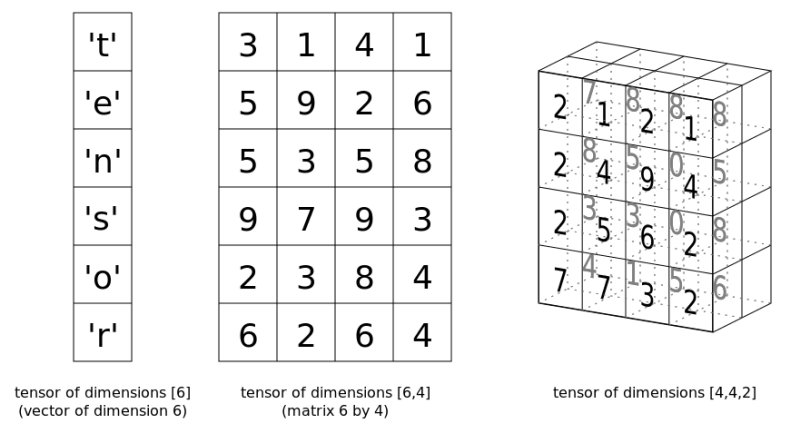

**What is a pytorch tensor ?** : A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.

Tensors are similar to NumPy’s ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing.

**How to define a pytorch tensor ?**
- using existing constructors : _torch.ones_ , _torch.zeros_ _torch.rand_
- based on existing object
    - from another tensor (or only using the shape of the other tensor)
    - from a python list
    - from a numpy array

In [ ]:
# define
ones = torch.ones(3,2)
# a tensor can be printed
print(ones)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])


In [ ]:
# other basic definition
print(torch.zeros(5,3), "\n",
      torch.rand(2,3), "\n",
      torch.empty(2,2))

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]) 
 tensor([[0.6271, 0.1150, 0.0343],
        [0.5437, 0.9372, 0.8815]]) 
 tensor([[7.2663e-31, 0.0000e+00],
        [3.5032e-44, 0.0000e+00]])


In [ ]:
# from a python list
ls = [[[1,3,5,6],[-1,4,4,4]],[[-1,-3,-5,-6],[10,-4,-4,-4]]]
tensor = torch.Tensor(ls)
print(tensor)
# from a numpy array :
array = np.array([0,1])
#array
tensor = torch.from_numpy(array)
print(tensor)
# symetrically  tensor.numpy()

tensor([[[ 1.,  3.,  5.,  6.],
         [-1.,  4.,  4.,  4.]],

        [[-1., -3., -5., -6.],
         [10., -4., -4., -4.]]])
tensor([0, 1])


If the list is not a proprer matrix shape, an exception is returned!

Uncomment the following cell to view the **error prompt**

In [ ]:
# # list must be in a proper matrix shape
# ls = [[[1,3,5,6],[-1,4,4,4]],[[-1,-3,-5,-6],[10,-4,-4]]]
# torch.Tensor(ls)

**Basic manipulations**
- access type / change data types
- access elements
- reshape
- maths opertions : add, multiply , ..
- differentiate / derive
- set to a specific _device_ : GPU , GPU:0, GPU:1 , CPU ...

In [ ]:
# get type
print(tensor,tensor.dtype)
# change type
tensor = tensor.float()

tensor([0, 1]) torch.int64


**NB** : types are important in Deep Learning  because :
- some types are more memory consumming than others : e.g : float16 vs float32
- some operations require specific type (cf. Embedding layer ...)

In [ ]:
tensor = torch.rand(5,2,2)
print(tensor)
# access one element
print(tensor[0,1,1])
# access several element
print(tensor[:3,0,:2])

tensor([[[0.0782, 0.6794],
         [0.1224, 0.7358]],

        [[0.7522, 0.5692],
         [0.4536, 0.3193]],

        [[0.0153, 0.5071],
         [0.0925, 0.9361]],

        [[0.3915, 0.1805],
         [0.4026, 0.6179]],

        [[0.5668, 0.2697],
         [0.1263, 0.0476]]])
tensor(0.7358)
tensor([[0.0782, 0.6794],
        [0.7522, 0.5692],
        [0.0153, 0.5071]])


**NB** : pytorch tensor indexing exactly match numpy indexing

In [ ]:
# get the shape of a tensor
tensor.size()
# reshape it
print(tensor, "\n",
      tensor.view(2,2,5))

tensor([[[0.0782, 0.6794],
         [0.1224, 0.7358]],

        [[0.7522, 0.5692],
         [0.4536, 0.3193]],

        [[0.0153, 0.5071],
         [0.0925, 0.9361]],

        [[0.3915, 0.1805],
         [0.4026, 0.6179]],

        [[0.5668, 0.2697],
         [0.1263, 0.0476]]]) 
 tensor([[[0.0782, 0.6794, 0.1224, 0.7358, 0.7522],
         [0.5692, 0.4536, 0.3193, 0.0153, 0.5071]],

        [[0.0925, 0.9361, 0.3915, 0.1805, 0.4026],
         [0.6179, 0.5668, 0.2697, 0.1263, 0.0476]]])


In [ ]:
intTensor = torch.ones(3,2, dtype=torch.float32)
print(intTensor, intTensor.dtype)
intTensor.int()

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]]) torch.float32


tensor([[1, 1],
        [1, 1],
        [1, 1]], dtype=torch.int32)

### <font color="teal">All operations on tensors</font>
- all reshape
- squeeze
- sum , prod
- max, norm ...

❗**Beware of Broadcasting** ❗ issues if your tensors does not have the same size. As in [Numpy broadcasting](https://numpy.org/devdocs/user/basics.broadcasting.html#general-broadcasting-rules), some operations above can broadcast, i.e. extend, their application to the size of the targeted tensor.

One really good explanation about PyTorch specific broadcasting can be found here: https://stackoverflow.com/questions/51371070/how-does-pytorch-broadcasting-work

Let's take the same example and reproduce it here.



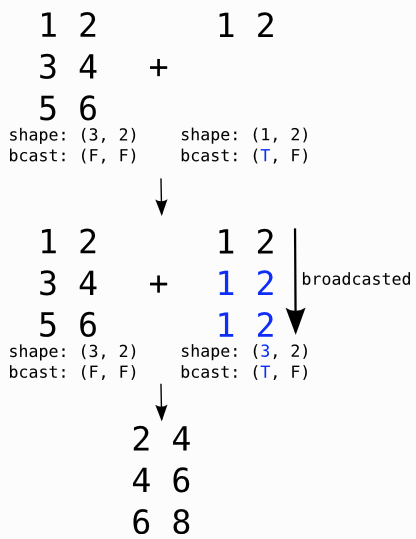

In PyTorch we reproduce it as follows:

In [ ]:
tensor_a = torch.Tensor([[1,2], [3,4], [5,6]])
tensor_b = torch.Tensor([1,2])
tensor_a + tensor_b

tensor([[2., 4.],
        [4., 6.],
        [6., 8.]])

## <font color="teal">Automatic Differentiation</font>

The core component of any modern deep learning library is _Automatic Differentiation_.


**Recall**
- Training any deep learning model requires backpropagatation
- Backpropagation is an algorithm that efficiently computes the gradient of a neural network's output based on its input and with regard to all its parameters (or also named weights)

_Automatic Differentiation_ provides a way of automatically computing gradients of any function. In other words, _automatic differentiation_ gives you the possibility to build complex neural network without caring about computing the gradients by yourself.


**NB**

Having access to an open source library that performs Automatic Differentation (tensorflow/pytorch and before Dynet or Theano..) is one of the reasons for the popularity and sucess of Deep Learning today.

### <font color="teal">Automatic Differentiation in a nutshell</font>


**Definition**
Automatic differentiation refers to a general way of taking a program which computes a value, and automatically constructing a procedure for computing derivatives of that value.

Automatic Differentation requires 3 steps

1. Building a computation Graph
2. propagating inputs throughout the graph (forward pass)
3. Computing gradient of each of the node in the graph (backward pass)

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
# double checking if gradient
print("Checking gradient is set to {}. Its gradient is still {} ".format(x.requires_grad, x.grad))

Checking gradient is set to True. Its gradient is still None 


In [ ]:
# let us define a basic operation
y = x+1
print(y)

tensor([[2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)


Do not fret due to the warning. It means that you are accessing the `.grad` field of a Tensor for which pytorch will never populate the `.grad` field.
This will not be the case later on.


In [ ]:
# y has now a gradient attribute , grad is none
y.grad_fn, y.grad

<ipython-input-36-825183a3e3bf>:2: UserWarning:

The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)



(<AddBackward0 at 0x7f6cb74d0610>, None)

In [ ]:
z = y * y * 3
out = z.mean()
print('z = ', z)
print('out = ', out)
print('z and y grad = ', z.grad, y.grad)

z =  tensor([[12., 12.],
        [12., 12.]], grad_fn=<MulBackward0>)
out =  tensor(12., grad_fn=<MeanBackward0>)
z and y grad =  None None


<ipython-input-37-00d402b4d864>:5: UserWarning:

The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)



In [ ]:
out.backward() # backpropagation
# Let's inspect the gradient at each previous variable' gradients now
print("Gradients with regard to intermediate nodes:", out.grad, z.grad, y.grad)
print("Gradients with regard to the input node that we considered to be the parameter:", x.grad)

Gradients with regard to intermediate nodes: None None None
Gradients with regard to the input node that we considered to be the parameter: tensor([[3., 3.],
        [3., 3.]])


<ipython-input-38-6fd590960a05>:3: UserWarning:

The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)



In [ ]:
# to manipulate a tensor without its gradient
out.detach()

tensor(12.)

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
print('x', x)
y = x+1
print('y', y)
# y.grad_fn, y.grad
z = y * y * 3
print('z', z)
out = z.mean()
print('out', out)
print('x grad', x.grad)
out.backward()
print('x grad', x.grad, x.grad.data, x.grad_fn)
print('y grad', y.grad, y.grad_fn)
print('z grad', z.grad, z.grad_fn)
print('out grad', out.grad, out.grad_fn)



x tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
y tensor([[2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)
z tensor([[12., 12.],
        [12., 12.]], grad_fn=<MulBackward0>)
out tensor(12., grad_fn=<MeanBackward0>)
x grad None
x grad tensor([[3., 3.],
        [3., 3.]]) tensor([[3., 3.],
        [3., 3.]]) None
y grad None <AddBackward0 object at 0x7f6cb74d08b0>
z grad None <MulBackward0 object at 0x7f6cb74d07f0>
out grad None <MeanBackward0 object at 0x7f6cb74d0130>


<ipython-input-40-c0cef70be14d>:13: UserWarning:

The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)

<ipython-input-40-c0cef70be14d>:14: UserWarning:

The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. 

In [ ]:
import torch

# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0)
z = x * y

# Displaying
for i, name in zip([x, y, z], "xyz"):
    print(f"{name}\ndata: {i.data}\nrequires_grad: {i.requires_grad}\n\
    grad: {i.grad}\ngrad_fn: {i.grad_fn}\nis_leaf: {i.is_leaf}\n")

x
data: 1.0
requires_grad: True
    grad: None
grad_fn: None
is_leaf: True

y
data: 2.0
requires_grad: False
    grad: None
grad_fn: None
is_leaf: True

z
data: 2.0
requires_grad: True
    grad: None
grad_fn: <MulBackward0 object at 0x7f6bfa827d30>
is_leaf: False



<ipython-input-41-03bb9f1eb50f>:11: UserWarning:

The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)



In [ ]:
import torch
# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
z = x ** 3
z.backward() #Computes the gradient
print(x.grad.data) #Prints '3' which is dz/dx

tensor(3.)


## <font color="teal">Pytorch Model</font>

Our goal is to define a deep learning model, train it, make prediction with it and evaluate it.

With pytorch this means doing the three following "scripts" :
1. Defining the model
2. Implementing the prediction
3. Implementing the training loop
    - Defining a loss
    - Defining an optimizer
    - Loop :
        - forward pass
        - backward pass
        - applying optimization update rule
4. Evaluating the model / playing with it
    - You can use the training criteria (loss) as your evaluation score
    - You can use another score : accuracy, F1 , ...

### <font color="teal">1. Defining the model</font>
Pytorch models always follow the same template :

- a class
- defining all layers (or parameters) in _init_()
- defining the forward pass in foward()

Let's see what it looks like with a simple 2 layers model.

All trivial Neural Network layers can generally be found in [torch.nn](https://pytorch.org/docs/stable/nn.html).

**Warning**: All your parametrized modules (Layers or any trainable vectors) must be defined as *direct* attributes to your ```nn.Module``` class so that the call to ```.backward()``` can properly propagate the gradients through everything. To define layers in list attribute, (resp. dictionary attributes) use ```ModuleList``` (resp. ```ModuleDict```).


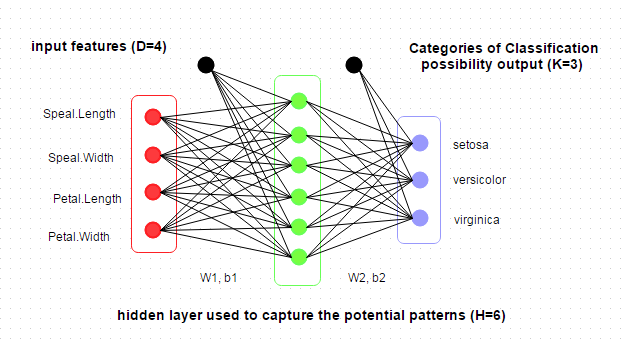



In [ ]:
# defining the model
class MinimalExampleModel(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(MinimalExampleModel, self).__init__()
        # define a first linear layer with an input dimension (D_in) and a Hidden dimension (H)
        # linear layer documentation: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        self.linear1 = torch.nn.Linear(D_in, H, bias=True)
        # define the final linear layer, often named classification layer as the output dimension (D_out) == the number of target classes
        self.linear2 = torch.nn.Linear(H, D_out, bias=True)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # first apply the linear1 layer on the vector and encapsulate it with an activation function for non linearization. This creates a dense layer.
        # relu documentation: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        h_relu = torch.relu(self.linear1(x))
        y_pred = self.linear2(h_relu)
        return y_pred

### <font color="teal">2. Forward pass</font>
1. instanciating the model
2. getting input data
3. computing the foward pass

In [ ]:
# instanciating the model with
# N:      batch size
# D_in:   input dimension
# H:      hidden dimension
# D_out:  output dimension
N, D_in, H, D_out = 2, 10, 10, 2

# Construct our model by instantiating the class defined above
# Note: all the parameters are initialized here
model = MinimalExampleModel(D_in, H, D_out)
# You can look up into the model
model

MinimalExampleModel(
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
# let's use torchinfo to have a better insight of the model infos: https://github.com/TylerYep/torchinfo
from torchinfo import summary
from termcolor import colored
dummy_input_size = (1, 10) # (batch_size, D_in)
summary(model, (N, D_in))

Layer (type:depth-idx)                   Output Shape              Param #
MinimalExampleModel                      --                        --
├─Linear: 1-1                            [2, 10]                   110
├─Linear: 1-2                            [2, 2]                    22
Total params: 132
Trainable params: 132
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
model = model.to(device)

#model = MyModel(D_in, H, D_out)
# forward pass / predict x
y_pred = model(x.to(device)) # almost equivalent to model.forward(x)
# y_pred
y_pred

DEVICE =  CPU


tensor([[0.1285, 0.4602],
        [0.0665, 0.2716]], grad_fn=<AddmmBackward0>)

#### 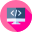 **TODO4! Think about it**
### <font color="chillipepper">Questions</font>
- Why do the prediction change if the model is re-instanciated ?
<font color="teal">Because the model first layer is initialized randomly and because the seed of the model is not fixed.</font>
- Can this be a problem ?
<font color="teal">Yes, if you really want some repoducibility on your code to demonstrate a method (i.e. in a scientific paper for instance)</font>
- How to avoid it ?
<font color="teal">You can set the seed for all PyTorch (not only for the this model).  You can also use pre-trained embeddings for instance.</font>

# <font color="teal">Unsupervised" Learning using PyTorch for Data Exploration</font>

In [ ]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from datasets import load_dataset
from tqdm import tqdm
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from termcolor import colored
from collections import Counter

from sacrebleu.metrics import BLEU

## <font color="teal">**Data Representation**</font>



We will use a corpus made of English-French translation pairs. This dataset comes from Tatoeba, https://tatoeba.org/fr/. You can find more datasets from this wbsite here: https://tatoeba.org/fr/downloads.

We will only consider English-French pairs, but you are free to try other pairs if you wish to do so.

Keep in mind this corpus is not the best one to train a good model, but machine translation model can be really long to train. Hence we chose this one to obtain quick, alas not good, results. You are free to try other datasets afterwards.

**Disclaimer:** The model should be trained for at least ~40 minutes to obtain somewhat "correct" results. Ideally, the model should be trained on the whole trainset, with multiple epochs. But we will NOT do this. You will see later on that with the `limit` option, we can easily select the subset size for training.

In [ ]:
! wget https://gitlab.com/gguibon/idmc-storage/-/raw/main/eng-fra.zip

! unzip eng-fra.zip

In [ ]:
from datasets import load_dataset
enfr = load_dataset('json', data_files='eng-fra.json')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-59ae88d3b51df6b7/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Our dataset only has a "train" set

In [ ]:
enfr

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 135842
    })
})

In [ ]:
# the number of telements in the train set
len(enfr['train'])

135842

In [ ]:
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

Let's try a simple tokenization on one element of the corpus

In [ ]:
tok = TweetTokenizer()
entry = enfr['train'][2]['translation']
tokens = tok.tokenize(entry['fr'].lower().strip())
print(tokens)

['courez', '!']


### <font color="teal">Build a Vocabulary from Scratch</font>

#### 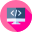 **TODO5: Count the vocab for both languages**



**Create your own vocab manually**, a dictionary `VOC` with multiple keys.
For each language `'en', 'fr'`:
- `counts`is the number of occurrence per token
- `stoi` is the String To Index mapping
- `itos` is the Index to String mapping
- `nbwords`is the global number of words




In [ ]:
# stoi string to index
# itos index to string

VOC = {'en': {'stoi': {}, 'counts': {}, 'nbwords': 0}, 'fr': {'stoi': {}, 'counts': {}, 'nbwords': 0}}
LANGS = ['fr', 'en']

def parse_entry(entry):
  for lang in LANGS:
    tokens = tok.tokenize(entry['translation'][lang].lower().strip())
    for t in tokens:
      if t not in VOC[lang]['stoi']:
        VOC[lang]['stoi'][t] = VOC[lang]['nbwords']
        VOC[lang]['counts'][t] = 1
        VOC[lang]['nbwords'] += 1
      else:
        VOC[lang]['counts'][t] = VOC[lang]['counts'][t] + 1

for lang in LANGS:
  for t in special_symbols:
    VOC[lang]['stoi'][t] = VOC[lang]['nbwords']
    VOC[lang]['counts'][t] = 1
    VOC[lang]['nbwords'] += 1

In [ ]:
for entry in tqdm(enfr['train']):
  parse_entry(entry)
for lang in LANGS:
  VOC[lang]['itos'] = { v:k for k,v in VOC[lang]['stoi'].items()}

100%|██████████| 135842/135842 [00:18<00:00, 7372.48it/s]


In [ ]:
print(VOC['fr']['itos'][1])

<pad>


In [ ]:
print('fr', VOC['fr']['nbwords'], 'en', VOC['en']['nbwords'])

fr 27185 en 13884


### <font color="teal">Add SOS and EOS special indices and Tokenize</font>



#### 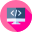 **TODO6: add SOS and EOS**

Add End of Sentence (EOS, `EOS_IDX`) and Start of Sentence (SOS, `SOS_IDX`) indices in the end and beginning of a list of tokens.

This means, for each `LANGS`, you will have to:
1. tokenize the sentence
2. transform the tokens to their corresponding indice
3. surround the tokens with the SOS and EOS indices

In [ ]:
print(VOC['fr']['stoi']['va'])

4


In [ ]:
enfr['train'][0]

{'translation': {'en': 'Go.', 'fr': 'Va !'}}

In [ ]:
def prepa(entry):
  res = {l:None for l in LANGS }
  for lang in LANGS:
    tokens_entries =  [ [SOS_IDX] + [ VOC[lang]['stoi'][t] for t in tok.tokenize(e[lang].lower().strip()) ] + [EOS_IDX] for e in entry['translation'] ]
    res[lang] = tokens_entries
  return res
enfr['train'] = enfr['train'].map(lambda e: prepa(e), batched=True)

  0%|          | 0/136 [00:00<?, ?ba/s]

In [ ]:
maxlen = max([max([ len(e) for e in enfr['train']['en'] ]), max([ len(e) for e in enfr['train']['fr'] ]) ] )

In [ ]:
maxlen = 10

### <font color="teal">Split into train, val, test</font>

Now let's split the dataset into train, val and test splits.

In [ ]:
from sklearn.model_selection import train_test_split
# we retrieve a list of indices (required for the .select() method of the hugging face dataset object - which is not a dictionary -)
indices = [i for i in range(len(enfr['train']))]
# use scikit learn to split the indices into subsets: ~67% train, ~16 % val, ~16% test
train_indices, other_indices, _, _ = train_test_split(indices, indices, test_size=0.33, random_state=42)
val_indices, test_indices, _, _ = train_test_split(other_indices, other_indices, test_size=0.5, random_state=42)

We now have the following sizes

In [ ]:
print(len(train_indices), len(val_indices), len(test_indices))

91014 22414 22414


And now we can use the indices lists to create subsets

In [ ]:
enfr['validation'] = enfr['train'].select(val_indices)
enfr['test'] = enfr['train'].select(test_indices)
enfr['train'] = enfr['train'].select(train_indices)

Let's look at the result

In [ ]:
enfr

DatasetDict({
    train: Dataset({
        features: ['translation', 'fr', 'en'],
        num_rows: 91014
    })
    validation: Dataset({
        features: ['translation', 'fr', 'en'],
        num_rows: 22414
    })
    test: Dataset({
        features: ['translation', 'fr', 'en'],
        num_rows: 22414
    })
})

## <font color="teal">Dataset and Dataloader</font>

#### 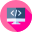 **TODO7: create the dataset and dataloaders**

You should know how to do it. We did it int the previous lab.

**Create the class** to serve the dataset items.

**Create the dataloaders** for each split. **Use batch_size to 1 !**

In [ ]:
from torch.utils.data import Dataset
import numpy as np

class EnfrDataset(Dataset):
    def __init__(self, data):
      self.data = data

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      item = {
          "en": np.array(self.data[idx]['en']),
          "fr": np.array(self.data[idx]['fr'])
      }
      return item

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(EnfrDataset(enfr['train']), batch_size=1, shuffle=True, drop_last=True)
val_loader   = DataLoader(EnfrDataset(enfr['validation']), batch_size=1, shuffle=True, drop_last=True)
test_loader  = DataLoader(EnfrDataset(enfr['test']), batch_size=1, shuffle=True, drop_last=True)

## <font color="teal">**The Model(s): Encoder Decoder**</font>

In this lab you will use an encoder-decoder for the same language... thus, an auto encoder 😃

### <font color="teal">CUDA, CPU, GPU, what is it?</font>

The GPU is the graphical processing unit, in order words: your graphic card. For computational purposes we mostly use Nvidia cards, which implements a dedicated language named CUDA. Hence, CUDA is available with all Nvidia cards such as the (impossible to get and overpriced) RTX 3090, Tesla, etc.

To enable GPU, please verify or change your execution parameters in "execution -> modify the execution type" and select "GPU".

Let's check our GPU

In [ ]:
# let's check our GPU if any
! nvidia-smi

Tue Mar 15 09:32:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

You can see this GPU is a Tesla K80 with CUDA Versio 11.2. It possesses ~11 Gb of RAM and is used at 0% (because we did not start any training).

Now let's check our CPU:

In [ ]:
# let's check our CPU
! lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

You can see our CPU (i.e. the processor), is an Intel Xeon with 2.30GHz cadency. This is ok, not the best, and it is necessary to prefer the GPU for computational speed. PyTorch let's you handle CPU and GPU as you wishes.

In [ ]:
# torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', colored('CPU', "blue"))

DEVICE =  Tesla T4


### <font color="teal">Define the Encoder</font>

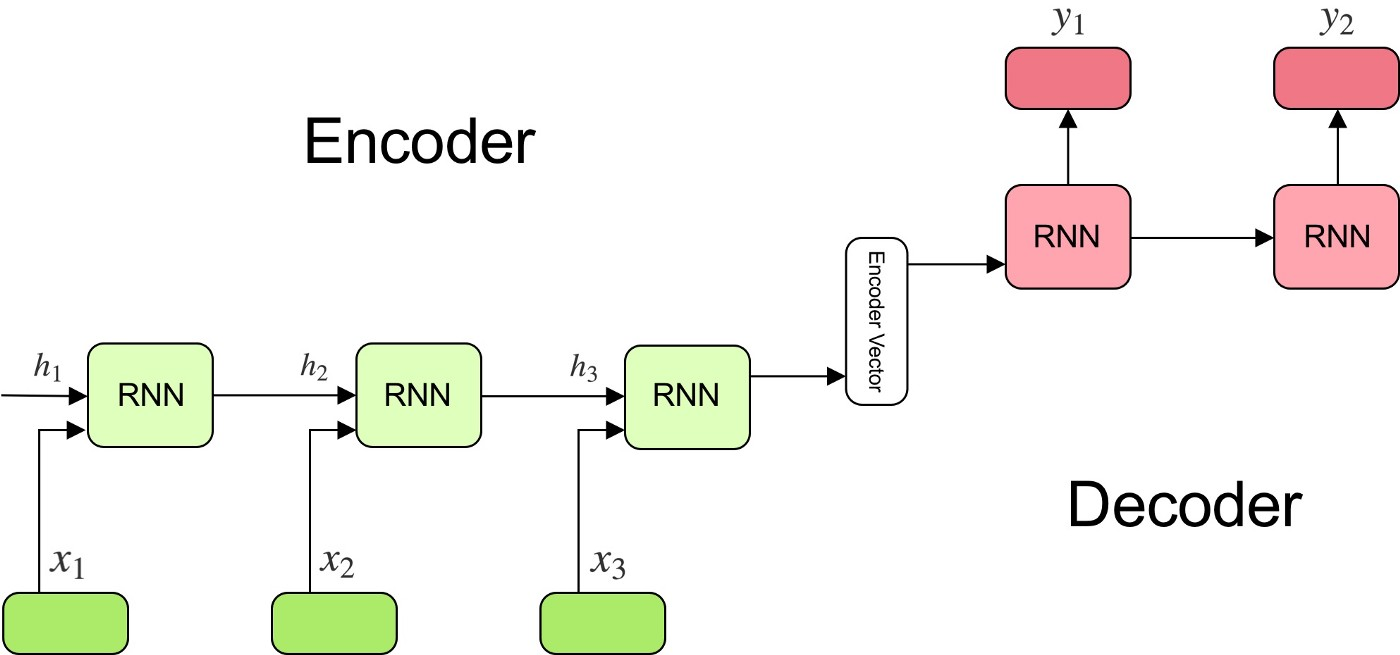

Source : https://towardsdatascience.com/understanding-encoder-decoder-sequence-to-sequence-model-679e04af4346

The encoder will encode the input, i.e. transform it into a vector of information as follows (source: https://ichi.pro/fr/traduction-automatique-neuronale-utilisant-un-modele-de-sequence-a-sequence-24508576939223):

<img src="https://miro.medium.com/max/724/1*R-Ul_DUk74cj79bPr5UalQ.gif" />

We use a recurrent layer for this. However, LSTM are complex and difficult, and long to train on such very small dataset. This is why we will use the Gated Recurrent Unit here. This model has [been made in 2014 for machine translation](https://paperswithcode.com/paper/learning-phrase-representations-using-rnn). It can be summed up as a simpler version of LSTM.


Links:
- https://pytorch.org/docs/stable/generated/torch.nn.GRU.html



Gated_Recurrent_Unit,_type_1.svg

#### 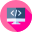 **TODO8: put the correct shape for the GRU layer**

Complete the following code (for both encoder and decoder) with the correct shape.

We pass an element at a time, but the GRU requires 3 dimensions.
Change the dimension of the embedded tensor using the `.view()` method.

Tips:
- https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size

        # we use an embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # we define a GRU layer (Gated Recurrent Unit), a simpler version of recurrent layer and way simple than LSTM
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
      # move the input to the dedicated device (CPU or GPU)
      input = input.to(device)
      # apply the embedding layer
      embedded = self.embedding(input)
      # modify the output shape in order for it to work with a GRU (we use batches of one element)
      output = embedded.view(1, 1, -1)
      # apply the GRU layer
      output, hidden = self.gru(output, hidden)
      # return both the output, and the hidden vector
      return output, hidden

    def initHidden(self):
        """
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

### <font color="teal">Define the Decoder</font>

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size

        # we use an embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # we define a GRU layer (Gated Recurrent Unit), a simpler version of recurrent layer and way simple than LSTM
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
      # move the input to the dedicated device (CPU or GPU)
        input = input.to(device)
        # apply the embedding layer and modify the output shape in order for it to work with a GRU (we use batches of one element)
        output = self.embedding(input).view(1, 1, -1)
        # apply a ReLU non linearization layer
        output = F.relu(output)
        # apply the GRU layer
        output, hidden = self.gru(output, hidden)
        # apply a softmax to get probabilities, on the first element of the output vector (batch is equal to one)
        output = self.softmax(self.out(output[0]))
        # return both the output probabilities and the hidden vector
        return output, hidden

    def initHidden(self):
        """
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

### <font color="teal">Encoder-Decoder in the Training Loop</font>

In [ ]:
import random
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=maxlen):
    # put both encoder and decoder into trainning mode
    encoder.train()
    decoder.train()

    # use our custom initialization of hidden vector
    encoder_hidden = encoder.initHidden()

    # remove the gradient to prevent gradient accumulation
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # adapt the tensor sizes
    input_tensor = input_tensor.view(input_tensor.size(1), input_tensor.size(0)) #input_tensor.view(1,1,-1)
    target_tensor = target_tensor.view(target_tensor.size(1), target_tensor.size(0)) #target_tensor.view(1,1,-1)

    # keep the lengths in memory
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # prepare an empty output with the correct size and the correct device
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # init the loss to 0
    loss = 0

    # pass each token of the input_tensor to the encoder, then populate the output
    for ei in range(input_length):
      if ei >= maxlen: break
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] = encoder_output[0, 0]

    # now we consider the decoder input, which starts only with the SOS token
    decoder_input = torch.tensor([[SOS_IDX]], device=device)

    # share the hidden vector from encoder to the decoder
    decoder_hidden = encoder_hidden

    # add a condition to teacher forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            # apply the NLL loss
            loss += criterion(decoder_output.to(device), target_tensor[di].to(device))
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
      # Without teacher forcing: use its own predictions as the next input
      for di in range(target_length):
          decoder_output, decoder_hidden = decoder(
              decoder_input, decoder_hidden)
          topv, topi = decoder_output.topk(1)
          decoder_input = topi.squeeze().detach()  # detach from history as input
          # compute the loss
          loss += criterion(decoder_output, target_tensor[di].to(device))
          # stop the iteration if the EOS token is predicted
          if decoder_input.item() == EOS_IDX:
              break

    # do the back propagation
    loss.backward()

    # notify each optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()

    # return the average loss
    return loss.item() / target_length

In [ ]:
def sentence2tensor(entry, lang):
  """
  Function to transform an entry sentence into its corresponding indices as a tensor.
  Needs to indicate the language to select the correct part of the vocabulary
  """
  indices = [SOS_IDX] + [ VOC[lang]['stoi'][t] if t in VOC[lang]['stoi'] else 0 for t in tok.tokenize(entry.lower().strip()) ] + [EOS_IDX]
  print(indices)
  return torch.tensor(indices)

def evaluate(encoder, decoder, sentence, input_lang, target_lang, max_length=maxlen, input_tensor=None, target_tensor=None, criterion=None):
    """
    function to evaluate a translation of one sentence
    """
    # we evaluate, so we don't need gradients -> torch.no_grad()
    with torch.no_grad():

        if target_tensor is None: target_length = 0
        else: target_length = target_tensor.size(0)

        encoder_hidden = encoder.initHidden()

        # this condition adapts the function to either use a sentence as input, or a tensor
        if input_tensor is None:
          input_tensor = sentence2tensor(sentence, input_lang)
          # adapts the decoding length, useful for validation or test
          decoding_length = max_length
        else:
          decoding_length = target_length

        input_length = input_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # iterate through the input length
        for ei in range(input_length):
            if ei >= maxlen: break
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_IDX]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        # init the loss (the loss is important is the cirterion is given - i.e. validation phase)
        loss = 0

        # iterate through decoding values, feeding the output for the next token until the condition or maximum lenght is reached
        for di in range(decoding_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_IDX:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(VOC[target_lang]['itos'][topi.item()])

            decoder_input = topi.squeeze().detach()

            if target_tensor != None and criterion is not None:
              loss += criterion(decoder_output.to(device), target_tensor[di].unsqueeze(0).to(device))
              if decoder_input.item() == EOS_IDX:
                break

        return decoded_words, loss

In [ ]:
def inference(target, loader, encoder, decoder, criterion, langorder, limit=0):
  """
  fucntion to apply the inference logic over multiple translation and return a score
  used for validation
  """
  encoder.eval()
  decoder.eval()
  loss_it, glue_it = list(), list()
  preds, trues = list(), list()

  total = loader.__len__()
  if limit > 0: total = limit

  # iterate through the loader, can be a validation or test loader
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=total):

    if limit > 0 and it >= limit: break

    input_tensor = batch[langorder[0]].squeeze()
    target_tensor = batch[langorder[1]].squeeze()

    input_lang = langorder[0]
    target_lang = langorder[1]
    # dummy sentence because this function is used for validation, not on-demand test
    mock_sentence = "dummy sentence not used"

    # compute entry and target sentences as "real text"
    entry = [VOC[input_lang]['itos'][t] for t in input_tensor.tolist()]
    entry = ' '.join( [e for e in entry if e not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
    true =  [VOC[target_lang]['itos'][t] for t in target_tensor.tolist()]
    true = ' '.join( [r for r in true if r not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
    trues.append([true])

    pred, loss = evaluate(encoder, decoder, mock_sentence, input_lang, target_lang, input_tensor=input_tensor, target_tensor=target_tensor, criterion=criterion)
    pred = ' '.join( [ h for h in pred if h not in ['<pad>', '<sos>', '<eos>', '<EOS>'] ] )
    preds.append(pred)
    if criterion is not None:
      try:
        loss_it.append(loss.item())
      except: pass
    else: loss_it.append(loss)

  bleu = BLEU()
  bleu_score = bleu.corpus_score(preds, trues)

  loss_it_avg = sum(loss_it)/len(loss_it)

  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), loss_it_avg, colored('blue', 'cyan'), bleu_score ))

  return trues, preds, loss_it_avg, loss_it, bleu_score

## <font color="teal">**Start Training 📉**</font>

In [ ]:
import torch.optim as optim

def run_epochs(encoder, decoder, max_epochs, learning_rate=0.01, langorder=['en','fr'], limit=0):

    # define the optimizer for both encoder and decoder separately.
    # You can change it later on
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    epoch_losses = []
    val_epoch_losses = []

    for ep in range(max_epochs):

      # TRAINING
      it_losses = []

      total = train_loader.__len__()
      # allow to limit the number of random samples per epoch
      if limit > 0: total = limit

      for iter, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=total):
          # trigger the limit if it is set
          if limit > 0 and iter >= limit: break

          input_tensor = batch[langorder[0]]
          target_tensor = batch[langorder[1]]

          loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
          it_losses.append(loss)

      epoch_loss = sum(it_losses)/len(it_losses)
      epoch_losses.append(epoch_loss)
      print("Epoch %s : %s : (%s %s) " % (colored(str(ep), 'blue'), colored('Training', 'blue'), colored('loss', 'cyan'), epoch_loss  ))


      # VALIDATION
      trues, preds, val_loss_it_avg, val_loss_it, bleu_score = inference("validation", val_loader, encoder, decoder, criterion, langorder, limit=limit)
      val_epoch_losses.append(val_loss_it_avg)


    return epoch_losses, val_epoch_losses

In [ ]:
# the hidden size is up to you, higher value yields longer training time
hidden_size = 512
langorder = ['en', 'en']
epochs = 10

# instanciate the encoder
encoder1 = EncoderRNN(VOC[langorder[0]]['nbwords'], hidden_size).to(device)
# instanciate the decoder
decoder1 = DecoderRNN(hidden_size, VOC[langorder[1]]['nbwords']).to(device)

# run the epochs
loss_list, val_loss_list = run_epochs(encoder1, decoder1, epochs, learning_rate=0.01, limit=200, langorder=langorder)

Epoch 0:: 100%|██████████| 200/200 [00:06<00:00, 29.86it/s]


Epoch 0 : Training : (loss 5.180725213154471) 


validation:: 100%|██████████| 200/200 [00:01<00:00, 154.02it/s]


validation : (loss 19.794791662693022) (blue BLEU = 0.00 100.0/100.0/100.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 1:: 100%|██████████| 200/200 [00:05<00:00, 39.27it/s]


Epoch 1 : Training : (loss 4.445313186874042) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 92.27it/s]


validation : (loss 54.814154167175296) (blue BLEU = 15.62 57.1/16.7/10.0/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 2:: 100%|██████████| 200/200 [00:05<00:00, 38.93it/s]


Epoch 2 : Training : (loss 4.311791720879123) 


validation:: 100%|██████████| 200/200 [00:01<00:00, 143.82it/s]


validation : (loss 23.857961311340333) (blue BLEU = 0.00 100.0/50.0/50.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 3:: 100%|██████████| 200/200 [00:05<00:00, 39.46it/s]


Epoch 3 : Training : (loss 4.2506606267027225) 


validation:: 100%|██████████| 200/200 [00:01<00:00, 110.27it/s]


validation : (loss 38.26641445159912) (blue BLEU = 19.88 87.5/42.9/8.3/5.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 4:: 100%|██████████| 200/200 [00:06<00:00, 32.57it/s]


Epoch 4 : Training : (loss 4.27933308480945) 


validation:: 100%|██████████| 200/200 [00:01<00:00, 108.52it/s]


validation : (loss 32.35981513977051) (blue BLEU = 26.86 100.0/25.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 5:: 100%|██████████| 200/200 [00:05<00:00, 37.06it/s]


Epoch 5 : Training : (loss 4.3159766507710335) 


validation:: 100%|██████████| 200/200 [00:01<00:00, 113.65it/s]


validation : (loss 35.39267601966858) (blue BLEU = 15.11 80.0/12.5/8.3/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 6:: 100%|██████████| 200/200 [00:05<00:00, 37.15it/s]


Epoch 6 : Training : (loss 4.294807058536904) 


validation:: 100%|██████████| 200/200 [00:01<00:00, 119.78it/s]


validation : (loss 32.61651967048645) (blue BLEU = 19.13 75.0/42.9/8.3/5.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 7:: 100%|██████████| 200/200 [00:05<00:00, 36.94it/s]


Epoch 7 : Training : (loss 4.230635714103221) 


validation:: 100%|██████████| 200/200 [00:01<00:00, 116.09it/s]


validation : (loss 33.08845644950867) (blue BLEU = 25.41 80.0/25.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 8:: 100%|██████████| 200/200 [00:05<00:00, 37.55it/s]


Epoch 8 : Training : (loss 4.14389384205268) 


validation:: 100%|██████████| 200/200 [00:01<00:00, 102.72it/s]


validation : (loss 40.058072309494015) (blue BLEU = 31.95 100.0/50.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 9:: 100%|██████████| 200/200 [00:05<00:00, 37.43it/s]


Epoch 9 : Training : (loss 4.089620319957407) 


validation:: 100%|██████████| 200/200 [00:01<00:00, 113.03it/s]

validation : (loss 33.55976472854614) (blue BLEU = 31.95 100.0/50.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.

  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  plt.ylabel('NLL')
  plt.title('lr: {}, optim_alg:{}'.format(0.01, 'SGD'))
  plt.show()

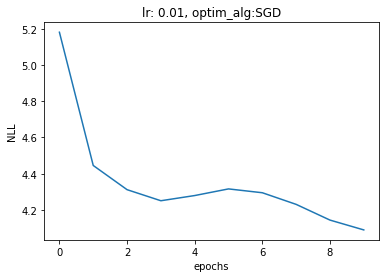

In [ ]:
# train loss
plot_loss(loss_list)

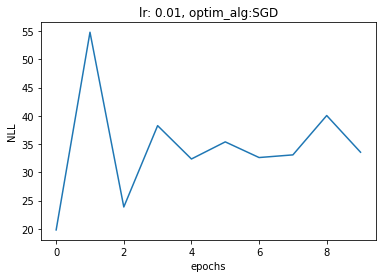

In [ ]:
# val loss
plot_loss(val_loss_list)

What would be the pros and cons of using batches?
- padding would break the performances
- left or right padding and trim would generate noisy data (missing data) in the temporal representation

## <font color="teal">**Evaluations 📊**</font>

### <font color="teal">Evaluate on Test 📊</font>

#### 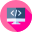 ☑️ **TODO9: Evaluate the model on the testset**

We use the BLEU score to evaluate our translation.

Here is the original paper: https://aclanthology.org/P02-1040.pdf

In [ ]:
trues, preds, test_loss_it_avg, test_loss_it, bleu_score = inference("test", test_loader, encoder1, decoder1, None, langorder, limit=1000)
print(bleu_score)

test:: 100%|██████████| 1000/1000 [00:08<00:00, 115.22it/s]


test : (loss 0.0) (blue BLEU = 45.18 100.0/66.7/25.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))
BLEU = 45.18 100.0/66.7/25.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4)


## <font color="teal">**Visualization**</font>

#### 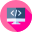 ☑️ **TODO10: Encode all the airline texts**

In [ ]:
def encode(encoder, sentence, input_lang, target_lang, max_length=maxlen, input_tensor=None, target_tensor=None):
    """
    function to only encode the sentence and return its vector
    """
    # we evaluate, so we don't need gradients -> torch.no_grad()
    with torch.no_grad():

        if target_tensor is None: target_length = 0
        else: target_length = target_tensor.size(0)

        encoder_hidden = encoder.initHidden()

        # this condition adapts the function to either use a sentence as input, or a tensor
        if input_tensor is None:
          input_tensor = sentence2tensor(sentence, input_lang)
          # adapts the decoding length, useful for validation or test
          decoding_length = max_length
        else:
          decoding_length = target_length

        input_length = input_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # iterate through the input length
        for ei in range(input_length):
            if ei >= maxlen: break
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        return encoder_hidden


In [ ]:
for sentence in df_airline["text"]:
  encode(encoder1, sentence, 'en', 'en').squeeze().cpu().tolist()
  break

[2, 0, 177, 0, 236, 5, 3]
[0.32698312401771545, -0.00802752934396267, -0.9368581175804138, 0.3746948540210724, 0.46055343747138977, 0.7070804238319397, 0.535474956035614, 0.4117598831653595, -0.5419137477874756, -0.5074414610862732, -0.40917861461639404, -0.1830378770828247, -0.03416106104850769, 0.18692797422409058, -0.3525756895542145, 0.6931478977203369, -0.30493199825286865, -0.4039751887321472, -0.2988695502281189, -0.4343041479587555, -0.14797241985797882, -0.4434316158294678, -0.49057430028915405, 0.5163930058479309, -0.09268737584352493, 0.7084773778915405, 0.2564977705478668, -0.6830040216445923, -0.1910957545042038, -0.46472132205963135, 0.6080028414726257, -0.7329863905906677, 0.049792107194662094, 0.5381994843482971, 0.2209038883447647, 0.4767167568206787, 0.4999096989631653, -0.07914259284734726, 0.03761090338230133, 0.7055284976959229, -0.19430334866046906, -0.07882891595363617, 0.6249163150787354, 0.4391005337238312, -0.5059987306594849, -0.5189618468284607, 0.4747540652

In [ ]:
encode(encoder1, "this is good", "en", "en").squeeze().size()

[2, 173, 211, 109, 3]


torch.Size([512])

In [ ]:
def encodeAll(target, loader, encoder, decoder, criterion, langorder, limit=0):
  encoder.eval()
  loss_it, glue_it = list(), list()
  preds, trues = list(), list()

  total = loader.__len__()
  if limit > 0: total = limit

  # iterate through the loader, can be a validation or test loader
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=total):

    if limit > 0 and it >= limit: break

    input_tensor = batch[langorder[0]].squeeze()
    target_tensor = batch[langorder[1]].squeeze()

    input_lang = langorder[0]
    target_lang = langorder[1]
    # dummy sentence because this function is used for validation, not on-demand test
    mock_sentence = "dummy sentence not used"

    # compute entry and target sentences as "real text"
    entry = [VOC[input_lang]['itos'][t] for t in input_tensor.tolist()]
    entry = ' '.join( [e for e in entry if e not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
    true =  [VOC[target_lang]['itos'][t] for t in target_tensor.tolist()]
    true = ' '.join( [r for r in true if r not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
    trues.append([true])

    pred, loss = evaluate(encoder, decoder, mock_sentence, input_lang, target_lang, input_tensor=input_tensor, target_tensor=target_tensor, criterion=criterion)
    pred = ' '.join( [ h for h in pred if h not in ['<pad>', '<sos>', '<eos>', '<EOS>'] ] )
    preds.append(pred)
    if criterion is not None:
      try:
        loss_it.append(loss.item())
      except: pass
    else: loss_it.append(loss)

  bleu = BLEU()
  bleu_score = bleu.corpus_score(preds, trues)

  loss_it_avg = sum(loss_it)/len(loss_it)

  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), loss_it_avg, colored('blue', 'cyan'), bleu_score ))

  return trues, preds, loss_it_avg, loss_it, bleu_score